# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero#try reverse img and mask
    masked_image = cv2.bitwise_and(mask, img)
    return masked_image
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_avg_lines(img, lines, color=[255, 0, 0], thickness=2):
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    average_and_extrapolate(img, lines, color=[255,0,0], thickness=2)
            
def average_and_extrapolate(img, lines, color=[255,0,0], thickness=6):
        slope_right=[]
        slope_left=[]
        right_yintercept=[]
        left_yintercept=[]        
        x_right=[]
        x_left=[]
        y_min=img.shape[0]
        for line in lines:
                for x1,y1,x2,y2 in line:
                    slope = get_slope(x1,y1,x2,y2)
                    yintercept = y1-slope*x1
                    y_min=min([y_min,y1,y2])
                    if slope > 0.2 and slope < 0.9:
                        slope_right.append(slope)
                        right_yintercept.append(yintercept)
                                                
                    elif slope > (-0.9) and slope < (-0.2):
                        slope_left.append(slope)
                        left_yintercept.append(yintercept)
                        
        avg_slope_right = np.mean(slope_right)
        avg_slope_left = np.mean(slope_left)
        avg_right_yintercept = np.mean(right_yintercept)
        avg_left_yintercept = np.mean(left_yintercept)
        

    #calculate final line end points
        right_y1=img.shape[0]    
        right_x1=int((right_y1 - avg_right_yintercept)/avg_slope_right)
        right_y2=y_min
        right_x2=int((right_y2 - avg_right_yintercept)/avg_slope_right)

        left_y1=img.shape[0]
        left_x1=int((left_y1 - avg_left_yintercept)/avg_slope_left)
        left_y2=y_min
        left_x2=int((left_y2 - avg_left_yintercept)/avg_slope_left)
        
        cv2.line(img,(right_x1,right_y1),(right_x2,right_y2),color,thickness)
        cv2.line(img,(left_x1,left_y1),(left_x2,left_y2),color,thickness)

        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    """ 
    #print out slopes of second hough lines and find out majority of slopes is between (0.623 to 0.67) and (-0.77 to -0.53)
    #use this info to set slope threshold 
    print('Number of end points:',len(lines))
    print('lines is',lines)
    for line in lines:    
        for x1,y1,x2,y2 in line:
            slope = get_slope(x1,y1,x2,y2)
            print('slope is',slope)
    """
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
def second_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    average_and_extrapolate(line_img, lines)
    return line_img
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
def get_slope(x1,y1,x2,y2):
    slope = (y2-y1)/(x2-x1)
    return slope
def number_of_points_in_hough(hough): #Out of curiosity
    total = 0
    for a in hough:
        total+=1
    print(total)
    
    

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

### Build your pipeline that will draw lane lines on the test_images, then save them to the test_images directory.


In [15]:
def lane_detector(image):
    #Grayscale the image
    gray = grayscale(image)
    plt.imshow(gray,cmap='gray')
    #plt.show()
    
    #Gaussian smooth the grayscale image
    blur_gray = gaussian_blur(gray, 5)
    #plt.imshow(blur_gray,cmap='gray')
    
    #Cannyedge the blurred image
    edges = canny(blur_gray,40,120)
    plt.imshow(edges,cmap='gray')
    #plt.show()
    
    #Draw hough lines on a blank image
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 12
    max_line_gap = 5
    lines_on_blank = hough_lines(edges,rho,theta,threshold,min_line_length,max_line_gap)
    plt.imshow(lines_on_blank)
    plt.show()
    
    #Define a trapezoide mask and draw out for adjusting
    left_bottom = [0.1*image.shape[1],image.shape[0]]
    left_apex = [0.46*image.shape[1],320]
    right_apex = [0.55*image.shape[1],320]
    right_bottom = [0.96*image.shape[1],image.shape[0]]
    pts = np.array([left_bottom,left_apex,right_apex,right_bottom])
    trapezoide = cv2.polylines(np.copy(image),np.int32([pts]),1,(0,0,255),thickness=4) #convert array to int32
    plt.imshow(trapezoide)
    plt.show()
    
    #Mask the lines_on_blank image
    lines_of_interest = region_of_interest(lines_on_blank, np.int32([pts]))
    #plt.imshow(lines_of_interest)
    #plt.show()
    
    #Draw lines_of_interest on test image
    weighted_image = weighted_img(lines_of_interest, image, α=0.8, β=1., λ=0.)
    plt.imshow(weighted_image)
    plt.show()
    
    #Apply a second hough transform on lines_of_interest and extrapolate
    hough_lines_of_interest = grayscale(lines_of_interest)
    hough_lines_of_interest = second_hough_lines(hough_lines_of_interest,rho,theta,threshold,min_line_length,max_line_gap)
    #plt.imshow(hough_lines_of_interest)
    
    #Plot the lines on the original image
    final_weighted_image = weighted_img(hough_lines_of_interest, image, α=0.8, β=1., λ=0.)
    #plt.imshow(final_weighted_image)
    
    return final_weighted_image


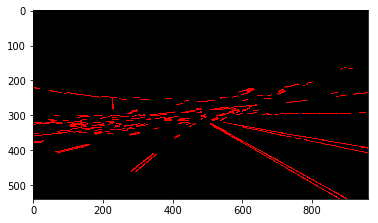

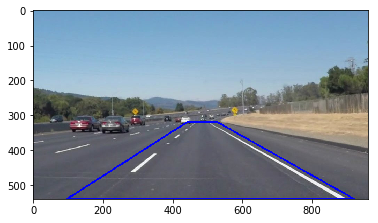

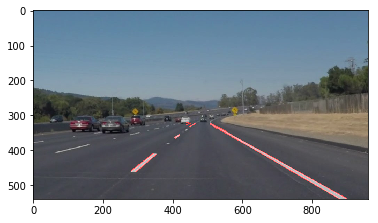

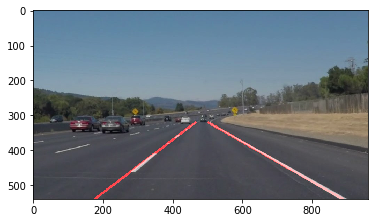

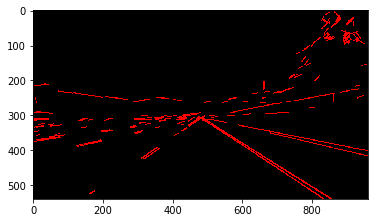

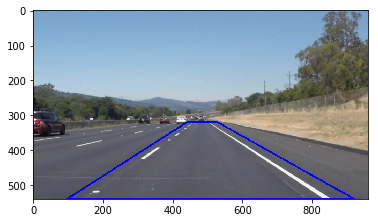

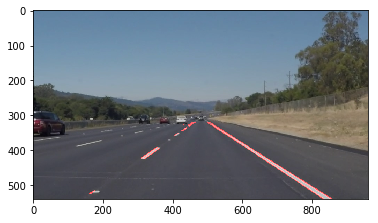

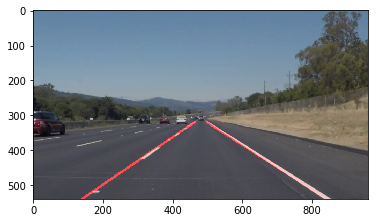

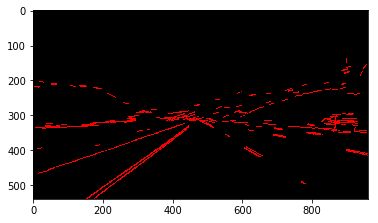

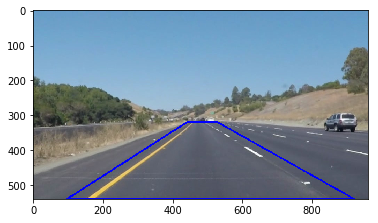

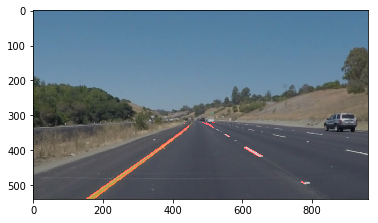

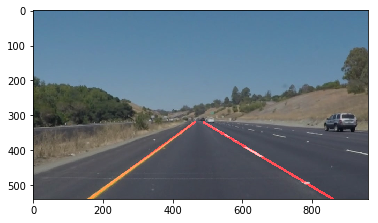

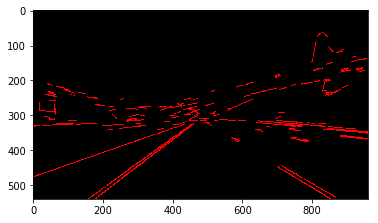

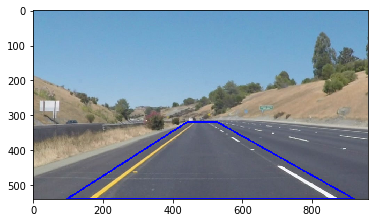

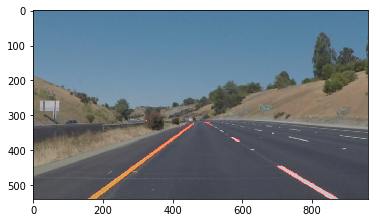

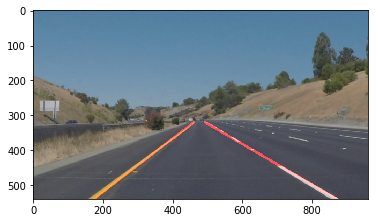

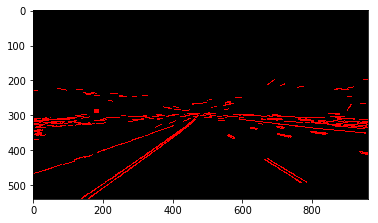

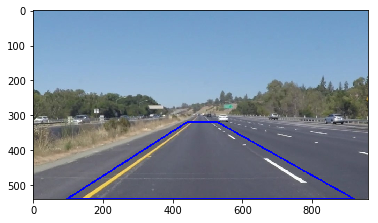

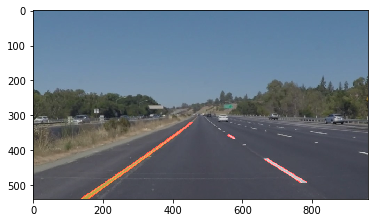

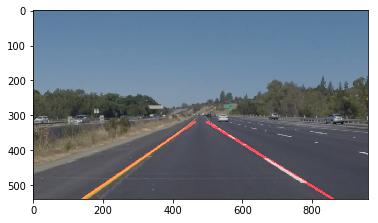

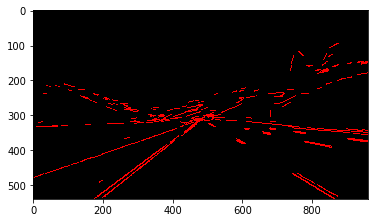

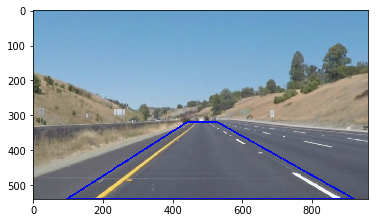

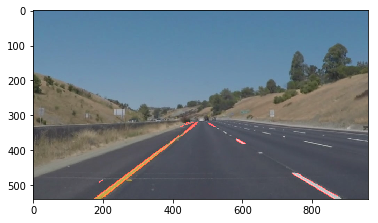

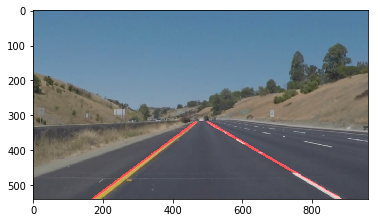

In [17]:
#test on all test images and save results
import glob
images_path = glob.glob('test_images/*.jpg')
images = []
results = []

for file in images_path:
    img = mpimg.imread(file)
    images.append(img)
    output = lane_detector(img)
    results.append(output)
    plt.imshow(output)
    plt.show()
    
    #mpimg.imsave('test_images_output/output_' + file[12::], lane_detector(img))


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = lane_detector(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


 99%|███████████████████████████████████████▋| 125/126 [00:17<00:00,  7.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 19.3 s


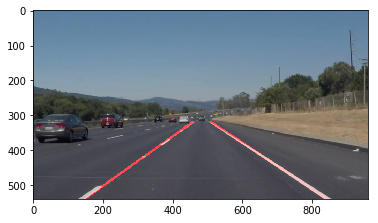

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


 99%|███████████████████████████████████████▋| 125/126 [00:19<00:00,  7.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 20.4 s


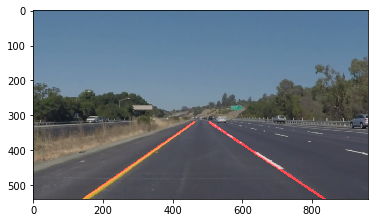

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))